In [1]:
import os
import time
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import RobertaForSequenceClassification, RobertaTokenizerFast, AdamW
import datasets
import pandas as pd
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.backends.cudnn as cudnn
pd.set_option('display.max_rows', None)

2023-06-29 18:46:28.040762: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 18:46:28.138571: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-06-29 18:46:28.507016: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-06-29 18:46:28.507076: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

In [2]:
ROOT_PATH = os.getcwd()
DATA_PATH = os.path.join(ROOT_PATH, '../../research_datasets/finetune_dataset/kge_sentiment_analysis')

# Set device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [3]:
# # Load the SST-5 dataset
dataset = pd.read_csv(DATA_PATH + '/train.tsv.zip', sep="\t")
train, valid = train_test_split(dataset, random_state=42, test_size = 0.1)

In [4]:
train, _ = train_test_split(train, random_state=42, test_size = 0.99)
valid, _ = train_test_split(valid, random_state=42, test_size = 0.99)

In [5]:
# Load the tokenizer
tokenizer = RobertaTokenizerFast.from_pretrained('roberta-base')

# Tokenize the dataset
def tokenize_dataset(dataset):
    encodings = tokenizer(dataset['Phrase'].tolist(), truncation=True, padding=True)
    labels = dataset['Sentiment'].tolist()
    return encodings, labels

train_encodings, train_labels = tokenize_dataset(train)
valid_encodings, valid_labels = tokenize_dataset(valid)

In [6]:
def get_encodings_df(encodings, idx):
    ids, tokens, attention_mask = [], [], []
    i = 0

    for get_ids in encodings[idx].ids:
        ids += [get_ids]
        
    for get_tokens in encodings[idx].tokens:
        tokens += [get_tokens.replace('Ġ', '')]

    for get_attention_mask in encodings[idx].attention_mask:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'ids': ids, 'tokens': tokens, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [7]:
# show_tokens_DF = get_encodings_df(test_encodings, 99)
# show_tokens_DF

In [8]:
def get_encodings_df(encodings, idx):
    input_ids, attention_mask = [], []
    i = 0

    for get_input_ids in encodings['input_ids'][idx]:
        input_ids += [get_input_ids]

    for get_attention_mask in encodings['attention_mask'][idx]:
        attention_mask += [get_attention_mask]
        i = i+1

    show_tokens_DF = pd.DataFrame({'input_ids': input_ids, 'attention_mask': attention_mask})
    print('got ' + str(i))
    return show_tokens_DF

In [9]:
# show_tokens_DF = get_encodings_df(test_encodings, 99)
# show_tokens_DF

In [10]:
# Create a torch dataset
class TsvDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __getitem__(self, idx):
        # item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item = {}
        item['input_ids'] = torch.tensor(self.encodings['input_ids'][idx])
        item['attention_mask'] = torch.tensor(self.encodings['attention_mask'][idx])
        item['labels'] = torch.tensor(self.labels[idx])

        return item

    def __len__(self):
        return len(self.labels)

In [11]:
train_dataset = TsvDataset(train_encodings, train_labels)
valid_dataset = TsvDataset(valid_encodings, valid_labels)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle=True, generator=torch.Generator(device='cuda'))

In [12]:
model = RobertaForSequenceClassification.from_pretrained('roberta-base', num_labels=5)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.bias', 'lm_head.layer_norm.bias', 'lm_head.dense.weight', 'lm_head.dense.bias', 'lm_head.layer_norm.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.weight', 'classifier.dense.bias', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should pr

In [13]:
class Trainer(object):
    '''This class takes care of training and validation of our model'''
    def __init__(self, model, train_loader, valid_loader, device=torch.device("cuda:0")):
        torch.set_default_tensor_type("torch.cuda.FloatTensor")
        cudnn.benchmark = True
        self.best_loss = float("inf")
        self.phases = ["train", "valid"]

        self.device = device
        self.dataloaders = {self.phases[0]: train_loader, self.phases[1]: valid_loader}
    
        self.lr = 5e-4
        self.num_epochs = 20
        self.accumulation_steps = 32 // self.dataloaders['train'].batch_size
        
        self.model = model.to(self.device)
        self.optimizer = AdamW(model.parameters(), lr=1e-5)
        # self.scheduler = ReduceLROnPlateau(self.optimizer, mode="min", patience=3, verbose=True)
        
        self.losses =   {phase: [] for phase in self.phases}
        self.accuracy = {phase: [] for phase in self.phases}

    def iterate(self, epoch, phase):
        running_loss = 0.0
        num_correct = 0
        num_samples = 0
        nowtime = time.strftime("%H:%M:%S")
        print(f"[{nowtime}] type: {phase} epoch: {epoch}")

        if phase == "train":
            self.model.train()
        else:
            self.model.eval()
        dataloader = self.dataloaders[phase]
        total_batches = len(dataloader)

        self.optimizer.zero_grad()
        pbar = tqdm(dataloader, total=len(dataloader), position=0, leave=True, desc=f"Epoch {epoch}")
        for itr, batch in enumerate(pbar):
            batch = {key: value.to(self.device) for key, value in batch.items()}
            outputs = self.model(**batch)
            loss = outputs.loss

            loss = loss / self.accumulation_steps
            if phase == "train":
                loss.backward()
                if (itr + 1 ) % self.accumulation_steps == 0:
                    self.optimizer.step()
                    self.optimizer.zero_grad()

            running_loss += loss.item()

            _, predictions = outputs['logits'].max(1)
            label = batch['labels']
            num_correct += (predictions == label).sum()
            num_samples += predictions.size(0)
            
        epoch_loss = (running_loss * self.accumulation_steps) / total_batches
        epoch_accuracy = (num_correct/num_samples).item()
        
        self.losses[phase].append(epoch_loss)
        self.accuracy[phase].append(epoch_accuracy)

        print("loss: %0.4f | accuracy: %0.4f" % (epoch_loss, epoch_accuracy))

        torch.cuda.empty_cache()
        return epoch_loss

    def start(self):
        for epoch in range(self.num_epochs):
            self.iterate(epoch, "train")
            state = {
                "epoch": epoch,
                "best_loss": self.best_loss,
                "state_dict": self.model.state_dict(),
                "optimizer": self.optimizer.state_dict(),
            }

            valid_loss = self.iterate(epoch, "valid")
            # self.scheduler.step(valid_loss)
            if valid_loss < self.best_loss:
                print("******** New optimal found, saving state ********")
                state["best_loss"] = self.best_loss = valid_loss
                nowtime = time.strftime("%H:%M:%S")
                # torch.save(state, "./" + nowtime + "model.pth")
            print()

In [14]:
model_trainer = Trainer(model, train_loader, valid_loader, device)
model_trainer.start()

/home/yasaisen/.local/lib/python3.8/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


[18:46:33] type: train epoch: 0


Epoch 0: 100%|██████████| 88/88 [00:10<00:00,  8.22it/s]


loss: 1.3888 | accuracy: 0.4979
[18:46:43] type: valid epoch: 0


Epoch 0: 100%|██████████| 10/10 [00:00<00:00, 29.58it/s]


loss: 1.3194 | accuracy: 0.4359
******** New optimal found, saving state ********

[18:46:44] type: train epoch: 1


Epoch 1: 100%|██████████| 88/88 [00:10<00:00,  8.56it/s]


loss: 1.1961 | accuracy: 0.5064
[18:46:54] type: valid epoch: 1


Epoch 1: 100%|██████████| 10/10 [00:00<00:00, 29.45it/s]


loss: 1.1764 | accuracy: 0.4423
******** New optimal found, saving state ********

[18:46:54] type: train epoch: 2


Epoch 2:  35%|███▌      | 31/88 [00:03<00:06,  8.31it/s]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:2                                                                                    │
│                                                                                                  │
│   1 model_trainer = Trainer(model, train_loader, valid_loader, device)                           │
│ ❱ 2 model_trainer.start()                                                                        │
│   3                                                                                              │
│                                                                                                  │
│ in start:71                                                                                      │
│                                                                                                  │
│   68 │                                                                                           │
│   69 │   def start(self):                                                                        │
│   70 │   │   for epoch in range(self.num_epochs):                                                │
│ ❱ 71 │   │   │   self.iterate(epoch, "train")                                                    │
│   72 │   │   │   state = {                                                                       │
│   73 │   │   │   │   "epoch": epoch,                                                             │
│   74 │   │   │   │   "best_loss": self.best_loss,                                                │
│                                                                                                  │
│ in iterate:48                                                                                    │
│                                                                                                  │
│   45 │   │   │   if phase == "train":                                                            │
│   46 │   │   │   │   loss.backward()                                                             │
│   47 │   │   │   │   if (itr + 1 ) % self.accumulation_steps == 0:                               │
│ ❱ 48 │   │   │   │   │   self.optimizer.step()                                                   │
│   49 │   │   │   │   │   self.optimizer.zero_grad()                                              │
│   50 │   │   │                                                                                   │
│   51 │   │   │   running_loss += loss.item()                                                     │
│                                                                                                  │
│ /home/yasaisen/.local/lib/python3.8/site-packages/torch/optim/optimizer.py:280 in wrapper        │
│                                                                                                  │
│   277 │   │   │   │   │   │   │   raise RuntimeError(f"{func} must return None or a tuple of (   │
│   278 │   │   │   │   │   │   │   │   │   │   │      f"but got {result}.")                       │
│   279 │   │   │   │                                                                              │
│ ❱ 280 │   │   │   │   out = func(*args, **kwargs)                                                │
│   281 │   │   │   │   self._optimizer_step_code()                                                │
│   282 │   │   │   │                                                                              │
│   283 │   │   │   │   # call optimizer step post hooks                                           │
│                                                                                                  │
│ /home/yasaisen/.local/lib/python3.8/site-packages/transformers/optimization.py:370 in step       │
│                                                                                                  │
│   367 │   │   │   │   │   bias_correction2 = 1.0 - beta2 **

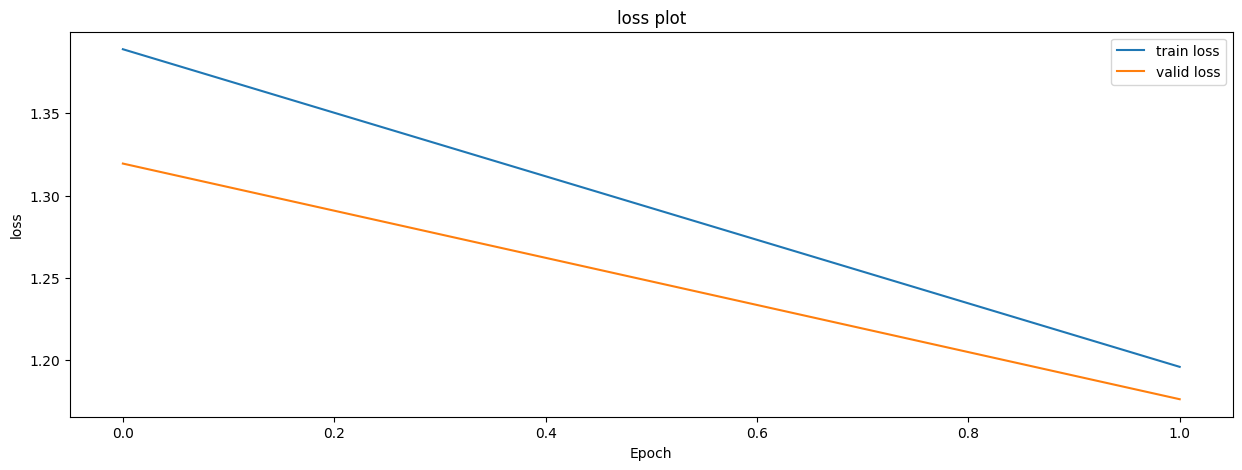

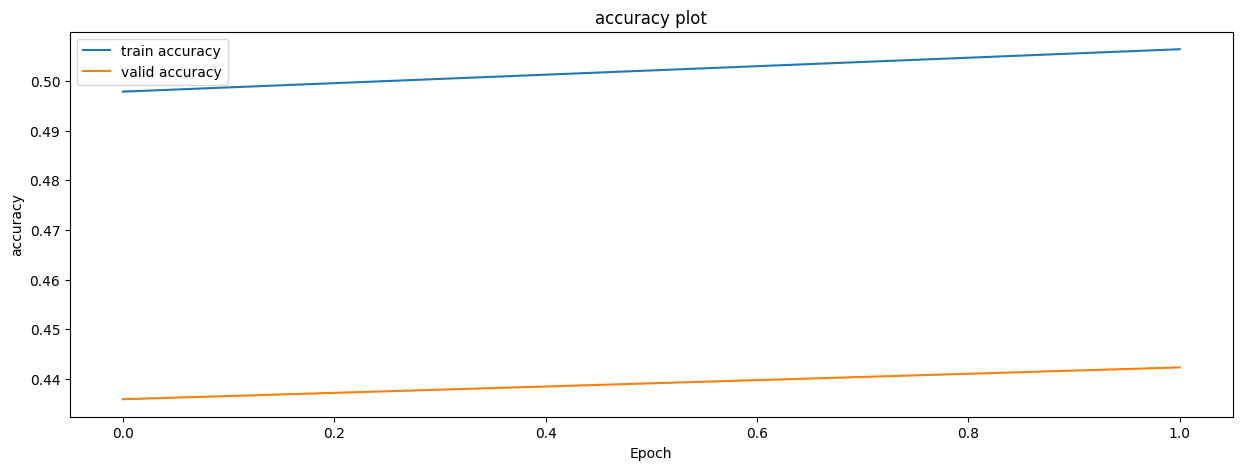

In [15]:
# PLOT TRAINING
losses = model_trainer.losses
accuracy = model_trainer.accuracy

def plot(scores, name):
    plt.figure(figsize=(15,5))
    plt.plot(range(len(scores["train"])), scores["train"], label=f'train {name}')
    plt.plot(range(len(scores["train"])), scores["valid"], label=f'valid {name}')
    plt.title(f'{name} plot')
    plt.xlabel('Epoch')
    plt.ylabel(f'{name}')
    plt.legend()
    plt.show()

plot(losses, "loss")
plot(accuracy, "accuracy")